In [30]:
using ScikitLearn.CrossValidation 
using Plots 
using Statistics
using PyCall 
using DataFrames 
using GLM  # Generalized Linear Models in Julia 
using CSV
using MLBase
using LsqFit
using RDatasets

In [4]:
#np = PyCall.pyimport("numpy")

PyObject <module 'numpy' from '/home/pabvald/.venv_py37/lib/python3.8/site-packages/numpy/__init__.py'>

## Data preparation

In [5]:
dataset = CSV.read("data/real-state.csv");
typeof(dataset)

DataFrame

In [6]:
dataset_names = names(dataset)

8-element Array{String,1}:
 "No"
 "X1 transaction date"
 "X2 house age"
 "X3 distance to the nearest MRT station"
 "X4 number of convenience stores"
 "X5 latitude"
 "X6 longitude"
 "Y house price of unit area"

We rename the dataset columns.

In [7]:
rename!(dataset, Symbol("X1 transaction date") => :X1,
                 Symbol("X2 house age") => :X2,
                 Symbol("X3 distance to the nearest MRT station")=> :X3,
                 Symbol("X4 number of convenience stores") => :X4,
                 Symbol("X5 latitude") => :X5,
                 Symbol("X6 longitude") => :X6,
                 Symbol("Y house price of unit area") => :Y                 
                )
names(dataset)

8-element Array{String,1}:
 "No"
 "X1"
 "X2"
 "X3"
 "X4"
 "X5"
 "X6"
 "Y"

In [8]:
X = Matrix(dataset[:,[:X1,:X2, :X3, :X4, :X5, :X6]]); # house features
Y = Vector(dataset[:,:Y]); # house price

In [9]:
size(X)

(414, 6)

In [10]:
size(Y)

(414,)

Since all the features have positive values, I scale the features so that they have the same weigth.

In [11]:
function standarize!(X)
    for col in Array(1:size(X,2))
        X[:,col] = (X[:, col] .- mean(X[:,col])) ./ std(X[:, col])
    end
end

function scale!(X)    
    for col in Array(1:size(X,2))
        minimum = min(X[:,col]...)
        maximum = max(X[:, col]...)
        X[:,col] = (X[:, col] .- minimum) ./ (maximum -minimum)
    end
end

scale! (generic function with 1 method)

In [12]:
scale!(X)

We can plot some of the features vs the house's price

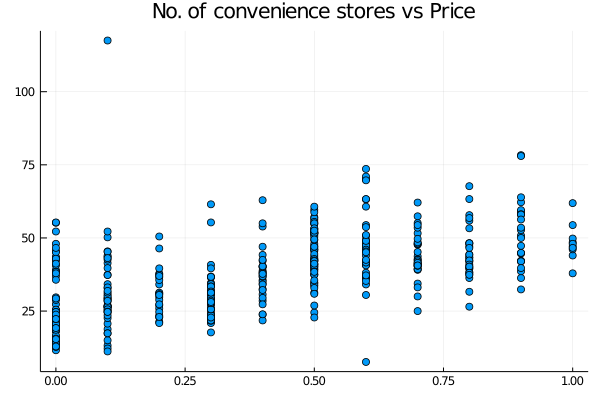

In [13]:
scatter(X[:,4], Y, label=nothing, title="No. of convenience stores vs Price")

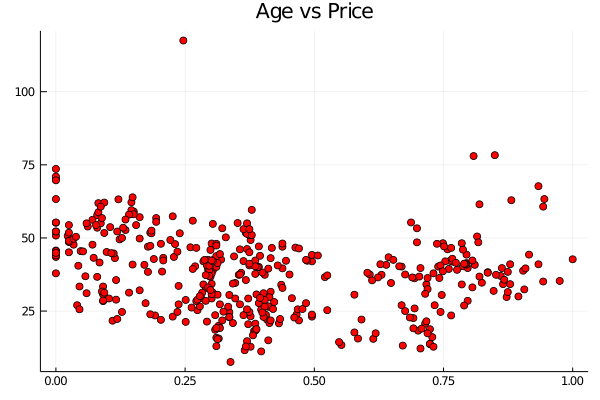

In [14]:
scatter(X[:,2], Y, label=nothing, title="Age vs Price", markercolor=:red)

## Linear Regression

In [63]:
?GLM.lm

```
lm(X, y, allowrankdeficient::Bool=false; wts=similar(y, 0))
```

An alias for `fit(LinearModel, X, y, allowrankdeficient)`

The arguments `X` and `y` can be a `Matrix` and a `Vector` or a `Formula` and a `DataFrame`.

The keyword argument `wts` can be a `Vector` specifying frequency weights for observations. Such weights are equivalent to repeating each observation a number of times equal to its weight. Do note that this interpretation gives equal point estimates but different standard errors from analytical (a.k.a. inverse variance) weights and from probability (a.k.a. sampling) weights which are the default in some other software.


#### a) Extracting the features and the Y in matrixes.

It is necessary to add a columns of 'ones' so that the LinearModel computes the intercept.

In [16]:
X1 = hcat(ones(size(X,1)),X[:,4]);
X1[1:4,:]

4×2 Array{Float64,2}:
 1.0  1.0
 1.0  0.9
 1.0  0.5
 1.0  0.5

In [17]:
model = lm(X1,Y)

LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}}:

Coefficients:
──────────────────────────────────────────────────────────────
      Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────
x1  27.1811     0.94192  28.86    <1e-99    25.3295    29.0327
x2  26.3765     1.86829  14.12    <1e-36    22.704     30.0491
──────────────────────────────────────────────────────────────


x1 is the intercept

#### b) Using the @formula macro

In [18]:
data = DataFrame(X=X[:,4], Y=Y)
model = lm(@formula(Y ~ X), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Y ~ 1 + X

Coefficients:
───────────────────────────────────────────────────────────────────────
               Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────
(Intercept)  27.1811     0.94192  28.86    <1e-99    25.3295    29.0327
X            26.3765     1.86829  14.12    <1e-36    22.704     30.0491
───────────────────────────────────────────────────────────────────────

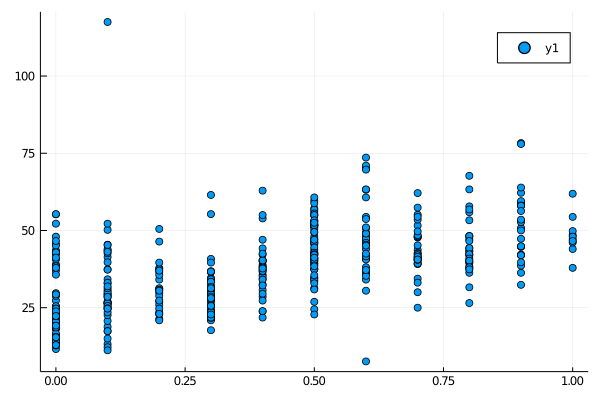

In [19]:
scatter(X[:,4], Y)

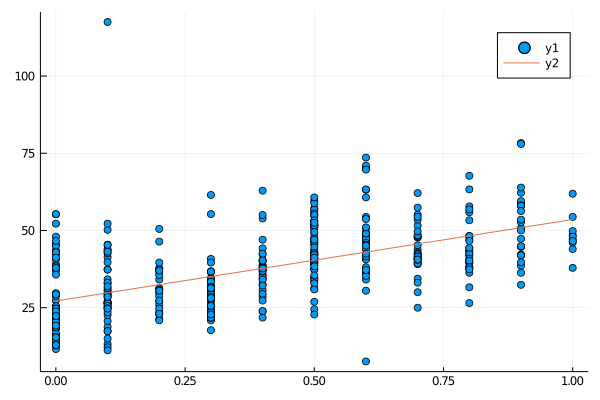

In [20]:
plot!(X[:,4], predict(model))

## Logistic Regression

In [21]:
function standarize!(X)
    for j = 1:size(X,2)
        X[:,j] = (X[:,j] .- mean(X[:,j])) ./ std(X[:,j])
    end
    nothing    
end

standarize! (generic function with 1 method)

There are cases when the predictions should be binary (0 or 1). In such cases, we can use logistic regression so that every predicted value is in the interval [0,1]. Once we have the predictions, we can set a threshold to determine which instances are classified as 0 and which ones are classified as 1. 

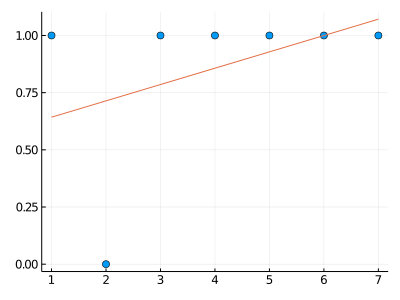

In [22]:
data = DataFrame(X=[1,2,3,4,5,6,7], Y=[1,0,1,1,1,1,1])
linear_reg = lm(@formula(Y ~ X), data)
scatter(data.X, data.Y, legend=false, size=(400,300))
plot!(data.X, predict(linear_reg))

To apply Logistic Regression, we will use a dataset contained in the RDataset.jl package.

In [23]:
cats = RDatasets.dataset("MASS", "cats");
standarize!(cats.BWt)
standarize!(cats.HWt)
describe(cats)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,Sex,,F,,M,2,,"CategoricalValue{String,UInt8}"
2,BWt,-6.96973e-16,-1.49104,-0.0486519,2.42401,,,Float64
3,HWt,3.51571e-16,-1.77873,-0.21792,4.05377,,,Float64


In [24]:
lmap = labelmap(cats.Sex)
le = labelencode(lmap, cats.Sex);
lmap

LabelMap (with 2 labels):
[1] F
[2] M


Female cats (blue) seem to be more present in the lower left corner and Males (orange) seem be present in the top right corner

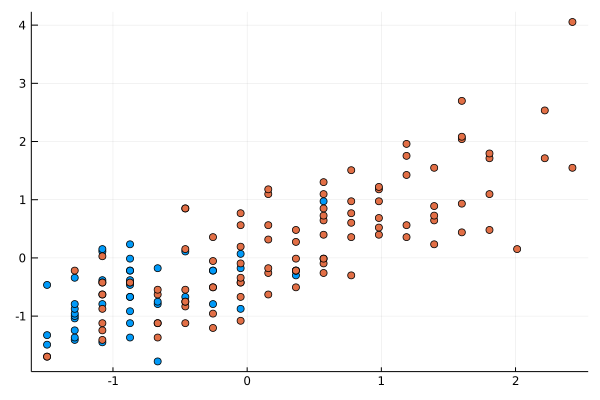

In [25]:
scatter(cats.BWt, cats.HWt, color=le, legend=false)

The *GLM* package allows to apply logistic regression by using the *Binomial()* distribution and the *LogitLink()* link function.

In [26]:
data = DataFrame(X1=cats.BWt, X2=cats.HWt, Y=le.-1)
logistic_reg = glm(@formula(Y ~ X1), data, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Y ~ 1 + X1

Coefficients:
──────────────────────────────────────────────────────────────────────
               Coef.  Std. Error     z  Pr(>|z|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────
(Intercept)  1.22128    0.267214  4.57     <1e-5   0.697547    1.74501
X1           1.76416    0.327353  5.39     <1e-7   1.12256     2.40576
──────────────────────────────────────────────────────────────────────

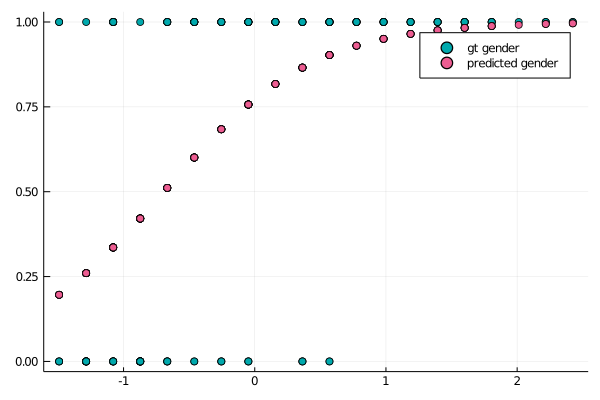

In [27]:
scatter(data.X1, data.Y, label="gt gender", color=6)
scatter!(data.X1, predict(logistic_reg), label="predicted gender", color=7)

## Non Linear Regression

Sometimes we might want to fit a non-linear function to a set of points. In such a case we can use the *LsqFit* package.

We can used some artificial data:

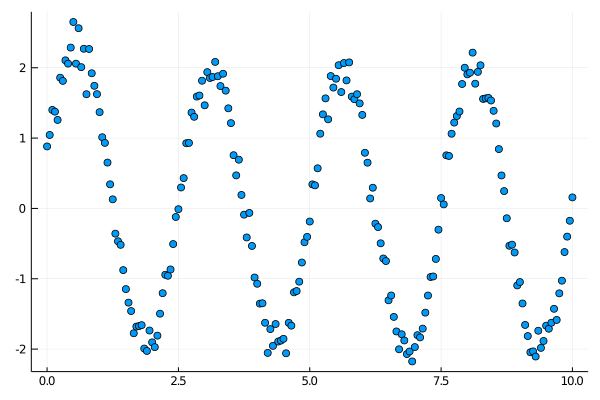

In [51]:
xvals = 0:0.05:10
yvals = 1*exp.(-xvals*2) + 2*sin.(0.8*pi*xvals) + 0.15 * randn(length(xvals));
scatter(xvals,yvals,legend=false)

In [60]:
@. nlmodel(x,p) = p[1]*exp(-x*p[2]) + p[3]*sin(0.8*pi*x)

nlmodel (generic function with 1 method)

In [61]:
p0 = [0.5, 0.5, 0.5]
nlfit = curve_fit(nlmodel, xvals, yvals, p0)

LsqFit.LsqFitResult{Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Float64,1}}([0.8757429665112211, 1.698487702493823, 1.9893619091483141], [-0.005597428649230407, 0.009275341845013774, -0.16687780107961814, 0.03552489758210631, 0.3238014673875884, -0.11619549704915921, 0.07464205868326146, -0.0895017545312724, 0.06469204343231238, -0.07864541373529033  …  -0.08978652588567759, -0.054338281086858675, -0.10588190351995896, 0.2233601639237075, 0.03769580373912995, 0.06902053887174942, -0.11207515944391455, -0.0938471284375218, -0.07401530339848988, -0.156991297152993], [1.0000000000052196 0.0 0.0; 0.9185817402187264 -0.040222074908445496 0.12533323355936565; … ; 4.575774015793474e-8 -3.9869757475265434e-7 -0.12533323356282172; 4.203130093641807e-8 -3.6807772838632534e-7 0.0], true, Float64[])

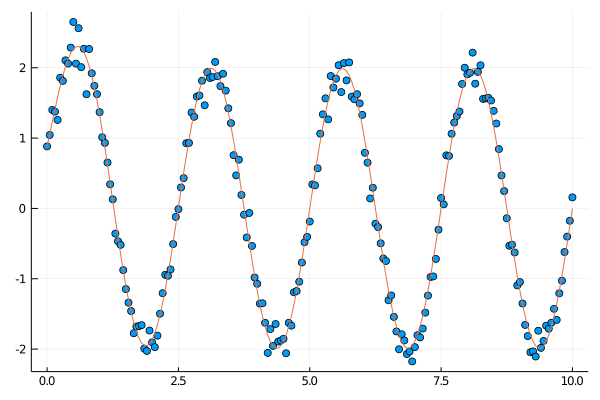

In [62]:
p = nlfit.param
findyvals = p[1]*exp.(-xvals*p[2]) + p[3]*sin.(0.8*pi*xvals)
scatter(xvals,yvals,legend=false)
plot!(xvals,findyvals)